# Treinamento com Neural Networks

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
url='https://drive.google.com/file/d/1GXJpU1eAKFoGABsy2CnfaP5dSHaoxHTY/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
raw_dataset = pd.read_csv(url)

features = [
    'win', 'firstBlood', 'firstTower', 'firstInhibitor',
    'firstBaron', 'firstDragon', 'firstRiftHerald', 'towerKills',
    'inhibitorKills', 'baronKills', 'dragonKills', 'riftHeraldKills',
    'kills', 'deaths', 'assists', 'visionScore', 'csPerMin',
    'goldPerMin', 'crowdControlTime'
]

to_drop_red  = ['red.' + feature for feature in features]

blue_dataset = raw_dataset.copy()
blue_dataset.drop(to_drop_red, axis=1, inplace=True)

In [3]:
def split_80_20(df, target_name):
    target = df[target_name]
    features = df.drop(target_name, 1)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def to_np(X_train, X_test, y_train, y_test):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_test  = X_test.to_numpy()
    y_test  = y_test.to_numpy()
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_80_20(blue_dataset, 'blue.win')
X_train_np, X_test_np, y_train_np, y_test_np = to_np(X_train, X_test, y_train, y_test)

In [5]:
print(X_train_np.shape)
print(y_train_np.shape)

(13017, 18)
(13017,)


# O modelo da rede neural

A rede neural é feita sobre o modelo sequencial do Keras e é constituída em: 

* Input Layer de 18 features.
* 3 Hidden Layers com ativação *selu*.
* Output Layer com apenas um neurônio (derrota = 0 | vitória = 1)

Além disso, a função de perda é definida como *binary crossentropy* e o otimizador é *Adam*.

# Treinamento da rede neural

Para treinar o modelo, os dados foram separados em 20% para teste e 80% para treino, com 10% destes para validação. Utilizamos a técnica de *Early Stopping* baseada no valor da função de perda no conjunto de validação e por isso que o número de épocas é alto.

Quanto ao tamanho do batch, escolhemos 32 pois o tempo de computação é razoável e garante resultados com mais precisão.

In [6]:
def neural_network(verbose=False, C=0):
  # Create a model
  model = tf.keras.Sequential()

  # Add layers
  model.add(layers.Flatten(input_shape=(18,)))
  model.add(layers.Dense(10, activation='selu',
                         kernel_regularizer=regularizers.L2(C)))
  model.add(layers.Dense(10, activation='selu',
                         kernel_regularizer=regularizers.L2(C)))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='Adam',
                metrics=[tf.keras.metrics.Precision(),
                         tf.keras.metrics.Recall(),
                         'accuracy'])

  # Fit model with early stopping
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
  model.fit(X_train_np, y_train_np, epochs=50, batch_size=32, validation_split=0.1,
            callbacks=[callback], verbose=verbose)

  # Test
  if verbose: print('\n')
  y_prediction = model.predict(X_test_np)

  _, precision, recall, accuracy = model.evaluate(X_test_np, y_test_np)
  return y_prediction, precision, recall, accuracy

# Exemplo de execução

In [7]:
y_prediction, precision, recall, accuracy = neural_network(verbose=True)

Epoch 1/50
367/367 [==============================] - 5s 7ms/step - loss: 42.6788 - precision: 0.6074 - recall: 0.7294 - accuracy: 0.6311 - val_loss: 0.6385 - val_precision: 0.8865 - val_recall: 0.7902 - val_accuracy: 0.8395
Epoch 2/50
367/367 [==============================] - 2s 5ms/step - loss: 0.3853 - precision: 0.8931 - recall: 0.8908 - accuracy: 0.8927 - val_loss: 0.1878 - val_precision: 0.9379 - val_recall: 0.9435 - val_accuracy: 0.9386
Epoch 3/50
367/367 [==============================] - 2s 5ms/step - loss: 0.1976 - precision: 0.9351 - recall: 0.9379 - accuracy: 0.9367 - val_loss: 0.1407 - val_precision: 0.9359 - val_recall: 0.9777 - val_accuracy: 0.9539
Epoch 4/50
367/367 [==============================] - 2s 5ms/step - loss: 0.1511 - precision: 0.9492 - recall: 0.9502 - accuracy: 0.9500 - val_loss: 0.1104 - val_precision: 0.9546 - val_recall: 0.9702 - val_accuracy: 0.9608
Epoch 5/50
367/367 [==============================] - 2s 4ms/step - loss: 0.1321 - precision: 0.9557 - 

# Rede neural com regularização

In [8]:
def conf_mat(prediction):
  """ Plotar matriz de confusão """
  for i in range(len(prediction)):
    prediction[i] = 0 if prediction[i] < 0.5 else 1
  
  result = confusion_matrix(y_test_np, prediction, normalize='pred')
  df2 = pd.DataFrame(result, index = [0,1], columns = [0,1])
  plt.figure(figsize = (8,6))
  ax = sn.heatmap(df2, annot=True, cmap='Purples', linewidths=1, linecolor='black')
  ax.set(xlabel='True label', ylabel='Predicted label', title='Confusion Matrix')
  plt.show()

In [9]:
C = [0, 0.001, 0.01, 0.1, 1.0, 10]
N = 5

Como criar uma rede neural reproduzível é relativamente complicado e pode apresentar resultados inesperadamente divergentes dependendo da inicialização dos pesos, pegaremos a média de N medidas para avaliar a regularização.

In [10]:
pred_arr = [None for _ in range(len(C))]
P, R, A = [], [], []

for c in range(len(C)):
    print(f"c: {C[c]}")
    best_acc = 0
    p, r, a = [], [], []
    
    for _ in range(N):
      prediction, precision, recall, accuracy = neural_network(C=C[c])
      p.append(precision)
      r.append(recall)
      a.append(accuracy)

      if accuracy >= best_acc:
        best_acc = accuracy
        pred_arr[c] = prediction

    P.append(np.mean(p))
    R.append(np.mean(r))
    A.append(np.mean(a))
    print()
    print(f"Mean & Std")
    print(f"Precision: {np.mean(p):.5f} & {np.std(p):.4f}")
    print(f"Recall:    {np.mean(r):.5f} & {np.std(r):.4f}")
    print(f"Accuracy:  {np.mean(a):.5f} & {np.std(a):.4f}")
    print()

c: 0
102/102 [==============================] - 0s 2ms/step - loss: 0.0691 - precision_5: 0.9697 - recall_5: 0.9787 - accuracy: 0.9745

Mean & Std
Precision: 0.95927 & 0.0156
Recall:    0.98238 & 0.0086
Accuracy:  0.97063 & 0.0046

c: 0.001
102/102 [==============================] - 0s 2ms/step - loss: 0.1487 - precision_10: 0.9931 - recall_10: 0.9025 - accuracy: 0.9490

Mean & Std
Precision: 0.94874 & 0.0473
Recall:    0.95775 & 0.0439
Accuracy:  0.95158 & 0.0170

c: 0.01
102/102 [==============================] - 0s 1ms/step - loss: 0.1537 - precision_15: 0.9369 - recall_15: 0.9937 - accuracy: 0.9641

Mean & Std
Precision: 0.92508 & 0.0271
Recall:    0.99337 & 0.0030
Accuracy:  0.95668 & 0.0148

c: 0.1
102/102 [==============================] - 0s 1ms/step - loss: 0.1918 - precision_20: 0.9715 - recall_20: 0.9581 - accuracy: 0.9656

Mean & Std
Precision: 0.95837 & 0.0207
Recall:    0.96987 & 0.0187
Accuracy:  0.96406 & 0.0044

c: 1.0
102/102 [==============================] - 0s 1ms/

In [16]:
def i(arr):
  return np.where(arr == np.amax(arr))[0][0]

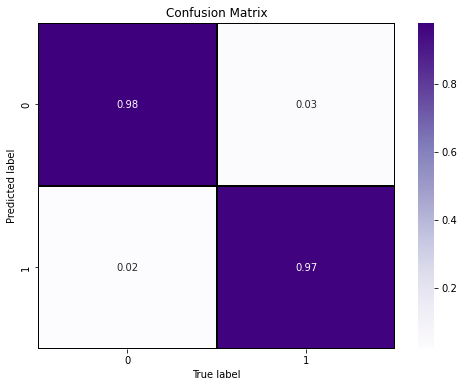

In [17]:
# Choose best overall
i = np.bincount([i(P), i(R), i(A)]).argmax()
conf_mat(pred_arr[i])

In [20]:
print(f"C: {C[i]}")
print(f"Precision: {P[i]:.5f}")
print(f"Recall:    {R[i]:.5f}")
print(f"Accuracy:  {A[i]:.5f}")

C: 0
Precision: 0.95927
Recall:    0.98238
Accuracy:  0.97063


# Resultados

A rede neural atingiu melhores resultados sem regularização com acurácia média de 97% e recall médio de 98% no conjunto de teste, o que apresenta aumento de performance de 5% comparado a baseline.